In [9]:
using Plots, Interact
include("AutomDiff_V2.jl")
import AD: Dual, xdual
pyplot(legend = :false, size = (500, 500))

Plots.PyPlotBackend()

In [6]:
mapins(x, M, S, R) = (R*x^2)/((R - 1)*(x^2)/M + S + x)

mapins (generic function with 1 method)

In [4]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 1000.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    nothing
end
"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        ff[:,ic] = xx
    end
    
    return ff
end

doc"""
    Lyapunov(y, F)

Dado un punto un arreglo que contenga todas las iteraciones bajo $F$ de $x_0$, calcula 
$\frac{1}{n} \sum_{i=1}^n \log\Big| \, f'(x_i)\, \Big|.$
"""
function Lyapunov(y, F::Function)
    n = length(y)
    l = 0
   
    for i in 1:n
        x = abs((F(xdual(y[i]))).der)
        l = l + log(x)
       
    end
    l/n
end

doc"""
    iterado(F,x0,n)

Dado un punto $x_0$, esta funció guarda a todas la iteraciones bajo $F$ en un arreglo.
"""
function iterado(F::Function,x0::Float64,n::Int)
    y = Float64[x0] ##El primer elemento es x_0
    x = x0
    for i in 1:n
        x=F(x) #El valor de x cambia con cada iteración
        push!(y,x) #Este nuevo valor se guarda en el arreglo
    end
    y
end



doc"""
mapeo_liap_all(crange::FloatRange, Qc::Function, x0::Float64, n = 100000)

Calcula el exponente de Lyapunov para un mapeo paramétrico $Q_c = Q_c(x, c)$ en un rango de parámetros `crange`, un
valor inicial `x0` y `n` iteraciones.
"""
function mapeo_liap_all(crange::FloatRange, Qc::Function, x0::Float64, n = 100_000)
    mapeo = Float64[]
  
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Lyapunov(y, Qci)
        if abs(l)<Inf #En algunos puntos labda diverge, por lo que si tiende a infinito, se la asigna el valor-2.5
            push!(mapeo,l)      
        else
            push!(mapeo,-2.5)       
        end
      
    end
    mapeo
end

mapeo_liap_all

In [ ]:
@manipulate for M in 0.1:0.1:10, R in 1.1:0.1:10
    m1(x, s) = mapins(x, M, s, R)
    srange = 0:200.0
    map1 = mapeo_liap_all(srange, m1, 1000.0)
    ff = diagbifurc(m1, 300, 10, srange); 
    cc = ones(size(ff)[1])*srange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
    ff = reshape(ff, size(ff)[1]*size(ff)[2]);
    cc = reshape(cc, size(ff));
    scatter(cc, ff, markersize= 0.05)
    ylims!(0, 10)
    #for l in eachindex(ff)
    #    if ff[l] == 0
    #        @show cc[l]
    #    end
    #end
end

In [11]:
M1 = 1:200
R1 = 1.1:0.1:200

1.1:0.1:200.0

In [2]:
function iteram(M1::Range, R1::Range)
    P, Q = length(R1), length(M1)
    Mat1 = zeros(P, Q) 
    K = Int(P*Q)
    n = 1
    #@show (P, Q)
    for j in 1:Q
        for i in 1:P
            if mod(100n/K, 10) == 0
                println(100n/K, "%")
            end
            #@show i, j
            M, R = M1[j], R1[i]
            m1(x, s) = mapins(x, M, s, R)
            srange = 0:2500.0
            #map1 = mapeo_liap_all(srange, m1, 1000.0)
            ff = diagbifurc(m1, 300, 50, srange); 
            cc = ones(size(ff)[1])*srange';
            
            # Esto cambia las matrices en vectores; ayuda un poco para los dibujos
            ff = reshape(ff, size(ff)[1]*size(ff)[2]);
            cc = reshape(cc, size(ff));
            for l in eachindex(ff)
                if ff[l] == 0
                    Mat1[i, j] = cc[l]
                    break
                end
            end
            n += 1
        end
    end

    mm = ones(size(Mat1)[1])*M1'
    rr = R1*ones(size(Mat1)[2])'
    A1 = reshape(Mat1, size(Mat1)[1]*size(Mat1)[2])
    mm1 = reshape(mm, size(A1)[1])
    rr1 = reshape(rr, size(A1)[1])
    return mm1, rr1, A1
end

iteram (generic function with 1 method)

In [12]:
mm1, rr1, A1 = iteram(M1, R1);
writecsv("mms1.csv", mm1)
writecsv("rrs1.csv", rr1)
writecsv("ccs1.csv", A1)

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%



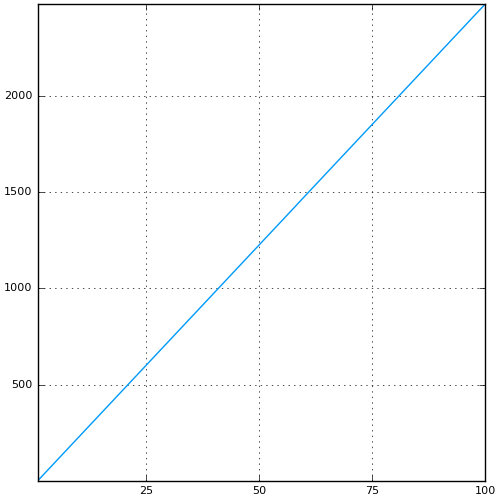

In [10]:
plot(rr1, A1)
#xlims!(80,83)

In [ ]:
#size(A1)

mm = reshape(mm1, size(A1));
rr = reshape(rr1, size(A1));

In [27]:
M, R = 200, 200
            m1(x, s) = mapins(x, M, s, R)
            srange = 0:9990.0
            #map1 = mapeo_liap_all(srange, m1, 1000.0)
            ff = diagbifurc(m1, 300, 50, srange); 
            cc = ones(size(ff)[1])*srange';
cs = 0
            # Esto cambia las matrices en vectores; ayuda un poco para los dibujos
            ff = reshape(ff, size(ff)[1]*size(ff)[2]);
            cc = reshape(cc, size(ff));
            for l in eachindex(ff)
                if ff[l] == 0
        cs = cc[l]
                    break
                end
            end
cs

9954.0

0

In [ ]:
A1 = readcsv("cs1.csv")[:,1]
mms = readcsv("ms1.csv")
rrs = readcsv("rs1.csv")
mm1 = reshape(mms, size(A1));
rr1 = reshape(rrs, size(A1));

In [ ]:
ls = 0
for j in eachindex(A1)
    if A1[j] == 0
        ls = j
        break
    end
end
ls

In [ ]:
unique(A1[ls:end])

In [ ]:
mm1

In [ ]:
typeof(mm1)


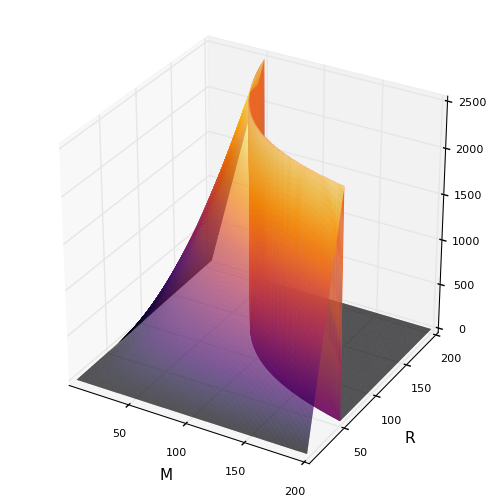

In [14]:
plot(mm1, rr1, A1,st = [:surface])
xlabel!("M")
ylabel!("R")

In [ ]:
A1

In [ ]:
mm3 = append!(mm, mm2)
rr3 = append!(rr, rr2)
A3 = append!(A1, A2);

In [ ]:
mm2 = reshape(mm2, size(A2));
rr2 = reshape(rr2, size(A2));

In [ ]:
M2 = 101:200
R2 = 1.1:0.1:100

In [ ]:
mm2, rr2, A2 = iteram(M2, R2);
writecsv("ms2.csv", mm2)
writecsv("rs2.csv", rr2)
writecsv("cs2.csv", A2)

In [ ]:
#writecsv("A1.csv", A1)
#writecsv("mm.csv", mm)
#writecsv("rr.csv", rr)


In [ ]:
M, R = 3, 1
    m1(x, s) = mapins(x, M, s, R)
    srange = 0:1000.0
    #map1 = mapeo_liap_all(srange, m1, 1000.0)
    ff = diagbifurc(m1, 1000, 256, srange); 
    ss = ones(size(ff)[1])*srange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
    ff1 = reshape(ff, size(ff)[1]*size(ff)[2]);
    ss1 = reshape(ss, size(ff));
    fi = Inf
    for l in eachindex(ff1)
        if ff1[l] == 0.0
        fi = l
        end
    end

In [ ]:
fi

In [ ]:
eachindex(ff)[10]

In [ ]:
cc[1000]

In [ ]:
scatter(cc, ff, markersize =0.1)

In [ ]:
fi

In [ ]:
using PyPlot

In [ ]:
Mat1

In [ ]:
imshow(Mat1)

show()

In [ ]:
for j in eachindex(ff)
    if ff[j] == 0
        return cc[j]
    end
end

In [ ]:
scatter(cc, ff, markersize= 0.05)

In [ ]:
scatter(srange, map1)
    #xlims!(0,200)
    #ylims!(0, 100)

In [ ]:
a1

In [ ]:
a1 = maximum(map1)
for j in eachindex(map1)
    if map1[j] == a1
        return srange[j]
    end
end